## Demo for Gaussian fit to data as a function of number of samples   - Richard Sear 2018


### NB This is a bit of rush job (11th Oct 2018), so may have bugs ...

### NB This does a three parameter fit of a Gaussian so it assumes that the far from the peak the values of $y$ tend to 0. For the trial data baked into this trial code this assumption is correct, but if you want to use this to fit data with a non-zero baseline you need to either: a) subtract this baseline off before fitting, b) modify the code to do a FOUR parameter fit in which the value of this baseline is an additional fit parameter 

Fits Gaussian and estimate uncertainties in the three parameters of a Gaussian (height, position and width) using bootstrap error estimation method.


Note that the maths behind estimating errors is pretty specialist and hairy stuff. This Jupyter Python notebook ignores this maths in favour of a being a cookbook with recipes for calculating estimates. Note that error ESTIMATES are just that, estimates, and so not guaranteed to be correct, in particular as the stats literature on these methods notes, all methods of obtaining error estimates make assumptions - if these assumptions are wrong so will be the error estimates. Notably the standard expressions given in stats textbooks (3 here) typically assume that the errors have a Gaussian distribution, which is often close to being true, but is not true in general.

The bootstrap method does not make this assumption, is a bit more flexible, and can be more accurate, than the jackknife method, and so is the one I would typically recommend. This [article](https://statistics.stanford.edu/sites/default/files/BIO%2083.pdf), although old, describes the idea of the bootstrap method very well, in a not-maths-heavy way. Note that the boostrap method can be used to give error estimates in anything where you are taking noisy data, and this article discusses the bootstrap method in estimating the error not in a fit but in estimating what they call the correlation coefficient.

Note that the bootstrap employs what is called resampling. Simply speaking the point of resampling is as follows. Ideally, we would like a huge number of data points, as then we could estimate the errors very accurately. More typically we only have a very limited number of points. We then use resampling that essentially recycles this small number of data points, by using them to approximately mimic the case where we had many more points.

In [1]:
# this makes the plots appear in this notebook
%matplotlib inline

######## We need to import modules into Python
# numpy is basic number crunching
import numpy as np
# need scipy routine to do fitting of data to a Gaussian
from scipy.optimize import curve_fit
# need a generator for random integers
from random import randint,gauss,seed
# matplolib is plotting module
import matplotlib.pyplot as plt
###################

need to define Gaussian function. Gaussian has THREE parameters: height, position and sigma (=width)

By construction this Gaussian tends to zero for $x$ values far from the peak.

In [2]:
def gaussian_func(x,height,position,sigma):
    return height*np.exp(-(x-position)**2/(2.0*sigma**2))

Normally you would read in data from a file - see commented out lines just below. But here, in order to make this IPython notebook self-contained, the data is built into the code as two arrays. The arrays are just 50 $x$ points plus the corresponding 50 $y$ points



In [3]:
# Normally read in data from a file, eg as in three lines immediately below, you can comment out and edit to do that 
#input_data=np.loadtxt("error_pi_vs_n.dat")
#x_data=input_data[:,0]
#y_data=input_data[:,1]
##############
# data from estimation of pi via MC sampling of points inside a circle inside a square below
x_data=[  50.   ,        51.53061224  , 53.06122449  , 54.59183673 ,  56.12244898,
   57.65306122 ,  59.18367347 , 60.71428571  , 62.24489796  ,  63.7755102,
   65.30612245 ,  66.83673469 , 68.36734694  , 69.89795918  ,  71.42857143,
   72.95918367 , 74.48979592  , 76.02040816  , 77.55102041  ,  79.08163265,
   80.6122449  ,  82.14285714 , 83.67346939  , 85.20408163  ,  86.73469388,
   88.26530612 ,  89.79591837 , 91.32653061  , 92.85714286  ,  94.3877551,
   95.91836735 ,  97.44897959 , 98.97959184  , 100.51020408 , 102.04081633,
   103.57142857 , 105.10204082 , 106.63265306 , 108.16326531 , 109.69387755,
   111.2244898  , 112.75510204 , 114.28571429 , 115.81632653 , 117.34693878,
   118.87755102 , 120.40816327 , 121.93877551 , 123.46938776 , 125.        ]
y_data=[  0.41377014 , -0.10495414 ,  0.37255293 ,  0.26160277 ,  0.08531372,
   0.34715966 , -0.54373545 ,  0.59889123 ,  0.01978427 , -0.54756711,
   0.0892631  , -0.39457362 ,  0.07430636 , -0.07620115 ,  0.61989377,
   0.55593698 ,  0.75163735 ,  0.76190345 , 2.26667747  , 1.73804388,
   3.30464748 ,  4.00552216 ,  5.45293876 ,  6.71058821 ,  7.30607101,
   8.56485589 , 10.2379816  , 10.93286798 , 11.55973729 , 12.66000605,
   12.2887081 , 11.58690386 , 10.9312787  ,  9.84442584 ,  9.07739439,
   7.79123061 ,  6.56966095 ,  5.49730277 ,  4.07648624 ,  2.89846001,
   2.29716244 ,  2.05079322 ,  1.07223863 ,  0.75650926 ,  0.56840469,
   0.12592929 ,  0.2472852  , -0.11232582 , -0.42348725 , -0.0497708 ]
n_pts=len(x_data)
print('data has ',n_pts,' points')
print(x_data)
print(y_data)
###########################################################
#n_pts=50
#x_data=np.linspace(50,125,n_pts)
#y_data=np.zeros(n_pts)
#for i in range(0,n_pts):
#    y_data[i]=gaus(x_data[i],12.1,95.1,8.9)+gauss(0.0,0.3)

data has  50  points
[50.0, 51.53061224, 53.06122449, 54.59183673, 56.12244898, 57.65306122, 59.18367347, 60.71428571, 62.24489796, 63.7755102, 65.30612245, 66.83673469, 68.36734694, 69.89795918, 71.42857143, 72.95918367, 74.48979592, 76.02040816, 77.55102041, 79.08163265, 80.6122449, 82.14285714, 83.67346939, 85.20408163, 86.73469388, 88.26530612, 89.79591837, 91.32653061, 92.85714286, 94.3877551, 95.91836735, 97.44897959, 98.97959184, 100.51020408, 102.04081633, 103.57142857, 105.10204082, 106.63265306, 108.16326531, 109.69387755, 111.2244898, 112.75510204, 114.28571429, 115.81632653, 117.34693878, 118.87755102, 120.40816327, 121.93877551, 123.46938776, 125.0]
[0.41377014, -0.10495414, 0.37255293, 0.26160277, 0.08531372, 0.34715966, -0.54373545, 0.59889123, 0.01978427, -0.54756711, 0.0892631, -0.39457362, 0.07430636, -0.07620115, 0.61989377, 0.55593698, 0.75163735, 0.76190345, 2.26667747, 1.73804388, 3.30464748, 4.00552216, 5.45293876, 6.71058821, 7.30607101, 8.56485589, 10.2379816, 

now define a function to fit to a Gaussian

NB starts SciPy's curve fit with:

1) max y value of data as initial guess for Gaussian's height

2) the corresponding value of x as the initial guess for Gaussian's position

3) (1/2)* area/height as the initial guess for the Gaussian's width

Note that if you do fits with more than 1 parameter, then fit program (here Scipy's curve_fit) can fail unless you give it sensible initial guess. Fortunately, if the data is basically one peak, then obtaining sensible guess as above is easy enough.

In [4]:
def fit_gauss(x_fit,y_fit):
# initial guess of Gaussian height is largest y value
    guess_height=np.amax(y_fit)
#    print('initial guess of Gaussian height is largest y value',format(guess_height,"6.3f"))
    guess_position=x_fit[np.argmax(y_fit)]
# initial guess of position is corresponding to largest y value
#    print('initial guess of position is corresponding to largest y value',format(guess_position,"6.3f"))
# initial guess of width is 0.5*area/height
    area=(np.sum(y_fit)/float(n_pts))*(np.amax(x_fit)-np.amin(x_fit))
    guess_width=0.5*area/guess_height
#    print('initial guess of width is 0.5*area/height',format(guess_width,"6.3f"))
    param_guess=[guess_height,guess_position,guess_width]
    bestfit_params,std_err_array=curve_fit(gaussian_func,x_fit,y_fit,p0=param_guess)
#    print(std_err_array)
    bestfit_height=bestfit_params[0]
    bestfit_position=bestfit_params[1]
    bestfit_width=bestfit_params[2]
#    print('best fit value of Gaussian height        ','%6.3f'%(bestfit_height),' from least squares fitting')
#    print('best fit value of Gaussian x position    ','%6.3f'%(bestfit_position))
#    print('best fit value of Gaussian width (sigma) ','%6.3f'%(bestfit_width))
    return bestfit_height,bestfit_position,bestfit_width

Now determine best fit values of Gaussian's height, position and width

In [5]:
fit_height,fit_position,fit_width=fit_gauss(x_data,y_data)
print('best fit value of Gaussian height        ','%6.3f'%(fit_height),' from least squares fitting')
print('best fit value of Gaussian x position    ','%6.3f'%(fit_position))
print('best fit value of Gaussian width (sigma) ','%6.3f'%(fit_width))

best fit value of Gaussian height         12.155  from least squares fitting
best fit value of Gaussian x position     95.202
best fit value of Gaussian width (sigma)   8.820


Now do boostrap error analysis, first define a function to do this. Wikipedia page for bootstrap is https://en.wikipedia.org/wiki/Bootstrapping_(statistics).

In [6]:
def bootstrap_calc(prob_conf_interval,x,y):
# here I have set the number of times the resampled to 100, this kind of overkill - making it 100 does not change the
# error estimates much - but as the program runs so quickly it would not run noticeably faster if n_bootstrap
# is reduced so might as well make n_bootstrap large
    n_bootstrap=1000
    boot_height=np.zeros(n_bootstrap)
    boot_position=np.zeros(n_bootstrap)
    boot_width=np.zeros(n_bootstrap)
    for i in range(0,n_bootstrap):
        x_boot=np.zeros(n_pts)
        y_boot=np.zeros(n_pts)
        for j in range(0,n_pts):
            i_sample=randint(0,n_pts-1)
            x_boot[j]=x[i_sample]
            y_boot[j]=y[i_sample]
        boot_height[i],boot_position[i],boot_width[i]=fit_gauss(x_boot,y_boot)#np.polyfit(x_boot,y_boot,1)
# sort so later we pick out values near bottom and top
    boot_height=np.sort(boot_height)
    boot_position=np.sort(boot_position)
    boot_width=np.sort(boot_width)
# now n_bootstrap values are sorted from smallest to largest
    f_lower=(1.0-prob_conf_interval)/2.0
    f_upper=1.0-f_lower
    print('lower and upper limits to confidence interval ',format(f_lower,"4.2f"),'&',format(f_upper,"4.2f"))
# 95% level confidence - 95% is just a reasonable but basically arbitrary choice
    n_boot_lower_conf=int(float(n_bootstrap)*f_lower)
    n_boot_upper_conf=int(float(n_bootstrap)*f_upper)
    min_boot_height=boot_height[n_boot_lower_conf]
    max_boot_height=boot_height[n_boot_upper_conf]
    min_boot_position=boot_position[n_boot_lower_conf]
    max_boot_position=boot_position[n_boot_upper_conf]
    min_boot_width=boot_width[n_boot_lower_conf]
    max_boot_width=boot_width[n_boot_upper_conf]
    return min_boot_height,max_boot_height,min_boot_position,max_boot_position,min_boot_width,max_boot_width

Now call this function to get the results, hopefully the confidence interval of the slope will include what we expect to be the true value $=-1/2$.

In [7]:
# Bootstrap estimates for statistical error bounds
# making this closer to 1 makes interval larger - more conservative error estimates
prob_conf_interval=0.95
print('estimate that',format(prob_conf_interval*100.0,"4.1f"),'% of the bootstrap sampled values fall with the confidence interval')
min_boot_height,max_boot_height,min_boot_position,max_boot_position,min_boot_width,max_boot_width=bootstrap_calc(prob_conf_interval,x_data,y_data)
print('')
print('after boootstrap error analysis the data constrains the fit parameters to ranges:')
print('best fit value of height      ',format(fit_height,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ',format(min_boot_height,"5.2f"),' to ',format(max_boot_height,"5.2f"))
print('best fit value of position    ',format(fit_position,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ','%5.2f'%(min_boot_position),' to ','%5.2f'%(max_boot_position))
print('best fit value of width       ',format(fit_width,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ','%5.2f'%(min_boot_width),' to ','%5.2f'%(max_boot_width))

estimate that 95.0 % of the bootstrap sampled values fall with the confidence interval
lower and upper limits to confidence interval  0.03 & 0.97

after boootstrap error analysis the data constrains the fit parameters to ranges:
best fit value of height       12.15  95.0 % conf. interval  11.94  to  12.39
best fit value of position     95.20  95.0 % conf. interval  95.04  to  95.37
best fit value of width         8.82  95.0 % conf. interval   8.62  to   9.03


Now plot data, best-fit, plus bootstrap error estimates to give rough idea of lowest reasonable line and highest reasonable line

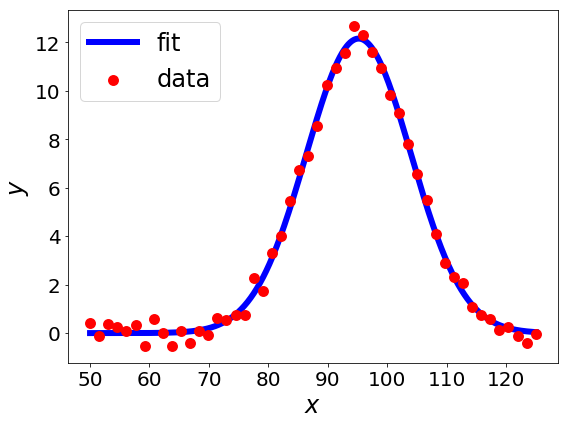

In [8]:
########### PLOT
# first generate points for fitted function
n_fitpts=1000
x_fit=np.linspace(np.min(x_data),np.max(x_data),n_fitpts)
# this is the best fit
y_fit=gaussian_func(x_fit,fit_height,fit_position,fit_width)
######### Now generate plot
plt.figure(figsize = (8,6) )
# plot data as scatter plot,
plt.scatter(x_data,y_data,s=120,color='red',linewidth=0,label='data',zorder=2)
# plot fitted function, zorder = 1 < 2 so line underneath points
plt.plot(x_fit,y_fit,linewidth=6,color='blue', label='fit',zorder=1)
plt.xlabel('$x$',fontsize=24)
plt.ylabel('$y$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
#	plt.legend(loc='upper right')
#	plt.axhline(color = 'gray', zorder=-1)
# save plot to file
#plt.savefig('tmp.pdf')
# display plot on screen
plt.show()

# Brief digression on checking if chosen fitting function (here Gaussian) is a reasonable choice

So far we have looked at the problem:if we ASSUME that the data is a Gaussian curve plus noise, what are our estimates for the values of the two parameters, intercept and slope, that define a straight line. This error analysis says essentially NOTHING about whether this assumption that the data really is a Gaussian, is true or false. Note that peaks in spectra etc can be Lorentzian (https://en.wikipedia.org/wiki/Lorentzian) which is a different functional form from a Gaussian, with very different tails

Perhaps the best simple check on the assumption for the functional form we chose for fitting, here a straight line, is to plot the residuals, ie the y values of the data minus the y values from the fit, as a function of x. IF the data really are a straight line plus noise, these residuals should just be random noise, ie no trend to increase or decreases with x. However, if the Gaussian is not the correct functional form, they a pattern in the residuals may be apparent.

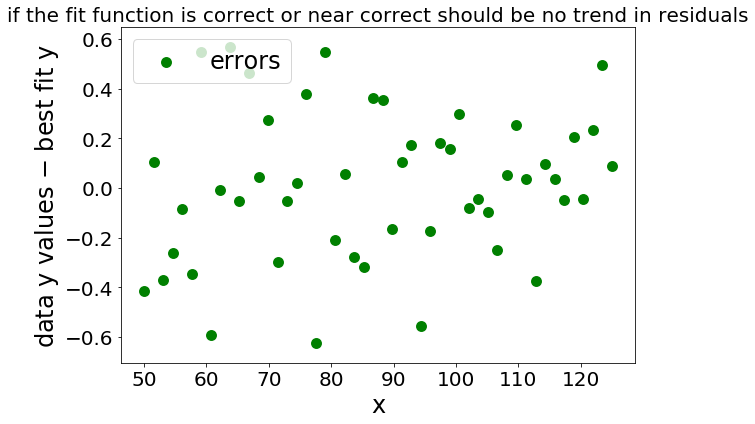

In [9]:
## plot errors to look for trend
######### Now generate plot
plt.figure(figsize = (10,6) )
# plot data as scatter plot,
plt.title('if the fit function is correct or near correct should be no trend in residuals',fontsize=20)
# these are the error or residuals in y values
y_fit_npts=gaussian_func(x_data,fit_height,fit_position,fit_width)
y_error=y_fit_npts-y_data
plt.scatter(x_data,y_error,s=120,c='green',linewidth=0,label='errors',zorder=2)
plt.xlabel('x',fontsize=24)
plt.ylabel('data y values $-$ best fit y',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
plt.show()

Note that these residuals just look like noise, ie no trend - as they should, we know that the data should be a straight line plus noise.